Exercise is meant for you to experiment with cython and numba to see how much efficiency can be obtained by using these two tools

In [1]:
import numpy as np
import seaborn as sb
import pandas as pd

In [2]:
class Particle:
  def __init__(self, x, y, ang_speed):
    self.x = x
    self.y = y
    self.ang_speed = ang_speed

In [3]:
def evolve_wrapper(dt, particles):
  timestep = 1
  nsteps = int(dt/timestep)
  r_i = np.array([[p.x, p.y] for p in particles])
  ang_speed = np.array([p.ang_speed for p in particles])
  evolve(r_i, ang_speed, timestep, nsteps)

  for i, p in enumerate(particles):
    p.x, p.y = r_i[i]

def evolve(r_i, ang_speed, timestep, nsteps):
  v_i = np.empty_like(r_i)
  for i in range(nsteps):
    norm_i = np.sqrt((r_i ** 2).sum(axis=1))
    v_i = r_i[:, [1,0]]
    v_i[:, 0] *= -1
    v_i /= norm_i[:, np.newaxis]
    d_i = timestep * ang_speed[:, np.newaxis] * v_i

    r_i += d_i

In [5]:
n_particle = 100
coord = np.random.randn(n_particle, 3)
particles = []
for i in range(0, n_particle):
  particles.append(Particle(coord[i][0], coord[i][1], coord[i][2]))

<AxesSubplot:xlabel='x', ylabel='y'>

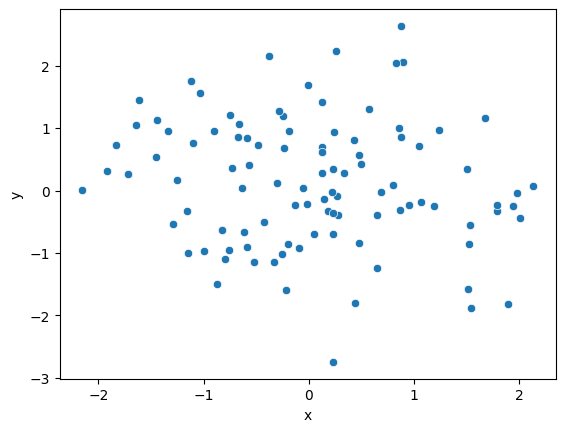

In [6]:
sb.scatterplot(x='x', y='y', data=pd.DataFrame([[p.x,p.y] for p in particles],columns = ['x', 'y']))

In [7]:
evolve_wrapper(1, particles)

<AxesSubplot:xlabel='x', ylabel='y'>

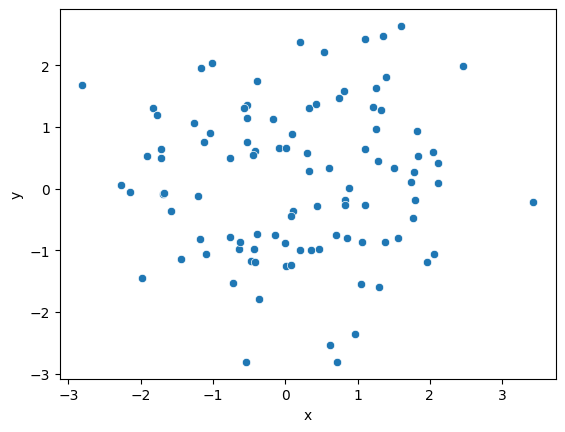

In [8]:
sb.scatterplot(x='x', y='y', data=pd.DataFrame([[p.x,p.y] for p in particles],columns = ['x', 'y']))

In [9]:
%timeit evolve_wrapper(1, particles)

245 µs ± 2.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Can you rewrite the evolve method to make it faster?

In [14]:
%load_ext Cython

In [17]:
%%cython
import numpy as np
from libc.math cimport sqrt

def static_evolve_wrapper(dt, particles):
  timestep = 1
  nsteps = int(dt/timestep)
  r_i = np.array([[p.x, p.y] for p in particles])
  ang_speed = np.array([p.ang_speed for p in particles])
  static_evolve(r_i, ang_speed, timestep, nsteps)

  for i, p in enumerate(particles):
    p.x, p.y = r_i[i]

def static_evolve(double[:, :] r_i, double[:] ang_speed_i, double timestep, int nsteps):
    cdef int i
    cdef int j 
    cdef int nparticles = r_i.shape[0]
    cdef double norm
    cdef double x, y 
    cdef double vx, vy
    cdef double dx, dy
    cdef ang_speed


    for nstep_idx in range(nsteps):
        for np_idx in range(nparticles):
            x = r_i[np_idx, 0]
            y = r_i[np_idx, 1]
            ang_speed = ang_speed_i[np_idx]

            norm = sqrt(x**2 + y**2)

            vx = (-y)/norm
            vy = x/norm

            dx = timestep * ang_speed * vx
            dy = timestep * ang_speed * vy

            r_i[np_idx, 0] += dx
            r_i[np_idx, 1] += dy


In [18]:
%timeit static_evolve_wrapper(1, particles)

210 µs ± 3.33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
